In [4]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image
import random


In [5]:
os.chdir('/Users/shubhampatel/Desktop/PRML/Assignment 3/Data/Synthetic Dataset')

In [6]:
syth = np.loadtxt('train.txt', delimiter=',')
syth[:,:2] = (syth[:,:2] - syth[:,:2].min(axis = 0))/(syth[:,:2].max(axis = 0)-syth[:,:2].min(axis = 0))

syth_d = np.loadtxt('dev.txt', delimiter=',')
syth_d[:,:2] = (syth_d[:,:2] - syth_d[:,:2].min(axis = 0))/(syth_d[:,:2].max(axis = 0)-syth_d[:,:2].min(axis = 0))
C1 = syth[syth[:,2] == 1, :2]
C2 = syth[syth[:,2] == 2, :2]

In [7]:
def stats(x):
    μ = x.mean(0)
    Σ = np.cov(x, rowvar=False)
    return (μ, Σ)

In [8]:
def gaussian(x, μ, Σ):
    d = len(μ)
    exponent = np.exp(-0.5*(x-μ)@np.linalg.inv(Σ)@(x-μ).T )
    det = 1/(np.linalg.det(Σ))**0.5
    gdf = 1/(2*np.pi)**(d/2)*det*exponent
    return gdf

In [9]:
def initial(x, K):
	n, d = x.shape
	μ_initial = np.zeros([K, d])
	Σ_initial = np.zeros([K, d, d])
	for k in range(K):
		index = random.randint(0, n)
		μ_initial[k,:] = x[index]
		Σ_initial[k,:,:] = stats(x)[1]
	return (μ_initial, Σ_initial)

In [10]:
def Kmeans(x, μ, K):
	n_tot, d = x.shape
	err = []
	N = np.zeros(K)
	distribution = np.zeros([n_tot, K])
	for n in range(n_tot):
		for k in range(K):
				err.append(np.linalg.norm(μ[k]-x[n]))
		err = np.array(err)
		i = np.argmin(err)
		N[i] += 1
		distribution[n, i] = 1
		err = []

	μ_new = np.zeros([K, d])
	for k in range(K):
		for n in range(n_tot):
			μ_new[k, :] += x[n]*distribution[n, k]
		μ_new[k, :] /= N[k]

	Σ_new = np.zeros([K, d, d])
	distortion = 0
	for k in range(K):
		for n in range(n_tot):
			Σ_new[k, :, :] += distribution[n, k]*np.eye(d)*((x[n]-μ_new[k]).reshape(d,1)@(x[n]-μ_new[k]).reshape(1,d))
			distortion += distribution[n, k]*np.linalg.norm(μ_new[k]-x[n])
		Σ_new[k, :, :] /= N[k]

	return (N, μ_new, Σ_new, distortion)

In [11]:
def GMM(x, π, μ, Σ, K):
	n_tot, d = x.shape
	r = np.zeros((n_tot, K))
	for n in range(n_tot):
		Sum = 0
		for k in range(K):
			Sum += π[k]*gaussian(x[n], μ[k], Σ[k])
		for k in range(K):
			r[n, k] = (π[k]*gaussian(x[n], μ[k], Σ[k]))/Sum

	N = np.zeros(K)
	π_new = np.zeros(K)
	for k in range(K):
		for n in range(n_tot):
			N[k] += r[n, k]
		π_new[k] = N[k]/n_tot
	
	μ_new = np.zeros((K, d))
	for k in range(K):
		for n in range(n_tot):
			μ_new[k, :] += r[n, k]*x[n]
		μ_new[k, :] /= N[k]

	Σ_new = np.zeros([K, d, d])
	distortion = 0
	for k in range(K):
		for n in range(n_tot):
			Σ_new[k, :, :] += r[n, k]*np.eye(d)*((x[n]-μ_new[k]).reshape(d,1)@(x[n]-μ_new[k]).reshape(1,d))
			distortion += r[n, k]*np.linalg.norm(μ_new[k]-x[n])
		Σ_new[k, :, :] /= N[k]

	return (π_new, μ_new, Σ_new, distortion)#np.eye(d)

In [12]:
def decision(x, ytest, n):
    xx, yy = grid(x, n)[:2]
    z = ytest.reshape(xx.shape)
    return (xx, yy, z)

In [13]:
def grid(x, n):
	min1, max1 = x[:, 0].min(), x[:, 0].max()
	min2, max2 = x[:, 1].min(), x[:, 1].max()
	x1grid = np.linspace(min1, max1, n)
	x2grid = np.linspace(min2, max2, n)
	xx, yy = np.meshgrid(x1grid, x2grid)
	xx, yy = np.meshgrid(x1grid, x2grid)
	r1, r2 = xx.flatten(), yy.flatten()
	r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
	grid = np.hstack((r1,r2))
	return (xx,yy,grid)

In [14]:
#fig = plt.figure(figsize=(10, 7))
## K Keans implementation
K = 16
μ1, Σ1 = initial(C1, K)
μ2, Σ2 = initial(C2, K)

N1, μ1, Σ1, dk1 = Kmeans(C1, μ1, K)
N2, μ2, Σ2, dk2 = Kmeans(C2, μ2, K)

for j in np.arange(1, 25):
	N1, μ1, Σ1, dk1 = Kmeans(C1, μ1, K)
	N2, μ2, Σ2, dk2 = Kmeans(C2, μ2, K)

# fig.add_subplot(rows,cols,1)
# plt.scatter(C1[:,0], C1[:,1], s=1, label ='Class 1')
# plt.scatter(C2[:,0], C2[:,1], s=1, label ='Class 2')
# plt.scatter(μ1[:,0], μ1[:,1], s=20, c = 'red', label ='Kmeans 1')
# plt.scatter(μ2[:,0], μ2[:,1], s=20, c = 'blue', label ='Kmeans 2')
# plt.title("Kmeans")
# plt.legend()



##GMM implementation
π1 = np.zeros(K)
π2 = np.zeros(K)
for k in range(K):
	π1[k] = N1[k]/C1.shape[0]
	π2[k] = N2[k]/C2.shape[0]

π1, μ1, Σ1, dg1 = GMM(C1, π1, μ1, Σ1, K)
π2, μ2, Σ2, dg2 = GMM(C2, π2, μ2, Σ2, K)

for j in range(5):
	π1, μ1, Σ1, dg1 = GMM(C1, π1, μ1, Σ1, K)
	π2, μ2, Σ2, dg2 = GMM(C2, π2, μ2, Σ2, K)

# print(dk1, dk2)
# print(dg1, dg2)

# fig.add_subplot(rows,cols,2)
# plt.scatter(C1[:,0], C1[:,1], s=1, label ='Class 1')
# plt.scatter(C2[:,0], C2[:,1], s=1, label ='Class 2')
# plt.scatter(μ1[:,0], μ1[:,1], s=20, c = 'red', label ='GMM 1')
# plt.scatter(μ2[:,0], μ2[:,1], s=20, c = 'blue', label ='GMM 2')
# plt.title("GMM")
# plt.legend()

# plt.show()

NameError: name 'yscore_d' is not defined

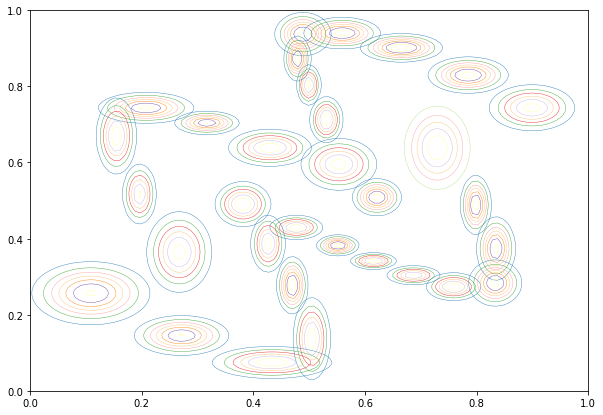

In [15]:
N = 100

fig = plt.figure(figsize=(10, 7))
#1)Contour lines
xx1, yy1, g1 = grid(C1[:,:2], N)
xx2, yy2, g2 = grid(C2[:,:2], N)
GDF1 = np.zeros((K,len(g1)))
GDF2 = np.zeros((K,len(g2)))
for k in range(K):
  for i in range(len(g1)):
    GDF1[k, i] = gaussian(g1[i], μ1[k], Σ1[k])
  for i in range(len(g2)):
    GDF2[k, i] = gaussian(g2[i], μ2[k], Σ2[k])

GDF1[np.where(GDF1 == 0)] = math.exp(-200)
GDF2[np.where(GDF2 == 0)] = math.exp(-200)

for k in range(K):
	zz1 = GDF1[k,:].reshape(xx1.shape)
	zz2 = GDF2[k,:].reshape(xx2.shape)
	plt.contour(xx1, yy1, zz1, linewidths=0.4, cmap='Paired')
	plt.contour(xx2, yy2, zz2, linewidths=0.4, cmap='Paired')   

#2)Decision Boundary
xtest = grid(syth[:, :2], N)[2]
P1 = np.zeros(len(xtest)); P2 = np.zeros(len(xtest))
for i in range(len(xtest)):
  for k in range(K):
    P1[i] += π1[k]*gaussian(xtest[i], μ1[k], Σ1[k])
    P2[i] += π2[k]*gaussian(xtest[i], μ2[k], Σ2[k])
P = np.vstack((P1, P2)).T

ytest = []; yscore=[]
for i in range(len(xtest)):
  ytest.append(np.argmax(P[i,:])+1)
  yscore_d.append(np.max(P[i,:]))
ytest = np.array(ytest); yscore = np.array(yscore)

xx, yy, z = decision(syth[:, :2], ytest, N)
plt.contourf(xx, yy, z, colors = ['springgreen','lightskyblue'], alpha = .5)

#3)GMM plots
#fig.add_subplot(rows,cols,2)
plt.scatter(C1[:,0], C1[:,1], s=1, label ='Class 1')
plt.scatter(C2[:,0], C2[:,1], s=1, label ='Class 2')
plt.scatter(μ1[:,0], μ1[:,1], s=20, c = 'red')
plt.scatter(μ2[:,0], μ2[:,1], s=20, c = 'blue')
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.title(f'GMM for K = {K} with Diagonal Covariance',fontweight="bold", fontsize=14)
plt.legend()

plt.show()

In [ ]:
def ROC(xtest, y_true, P):
    
    TPR = []; FPR = []
     
    threshold_min, threshold_max = np.log10(P).min(), np.log10(P).max()
    threshold_vec = np.linspace(threshold_min, threshold_max, dtype=float, num=100)
    for t in threshold_vec:
        TP, FP = 0, 0
        TN, FN = 0, 0
        threshold = 10**(t)
        y_predict = []
        for i in range(len(xtest)):
            if P[i,0]/(P[i,0]+P[i,1])>=threshold:
                y_predict.append(1)
            else:
                y_predict.append(2)
        y_predict = np.array(y_predict)

        for i in range(len(xtest)):
            if y_predict[i] == 1 and y_true[i] == 1:
                TP += 1
            elif y_predict[i] == 1 and y_true[i] == 2:
                FP += 1
            elif y_predict[i] == 2 and y_true[i] == 1:
                FN += 1
            else:
                TN += 1

        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
    return (TPR, FPR)

In [ ]:
xtest = syth_d[:,:2]
P1 = np.zeros(len(xtest)); P2 = np.zeros(len(xtest))
for i in range(len(xtest)):
  for k in range(K):
    P1[i] += π1[k]*gaussian(xtest[i], μ1[k], Σ1[k])
    P2[i] += π2[k]*gaussian(xtest[i], μ2[k], Σ2[k])
Pd = np.vstack((P1, P2)).T
y_true = syth_d[:,2] 
fig = plt.figure(figsize=(10, 7))
(TPR, FPR) = ROC(xtest, y_true, P)
(TPRd, FPRd) = ROC(xtest, y_true, Pd)
plt.plot(FPR, TPR, 'b')
plt.plot(FPRd, TPRd, 'r')
plt.xlabel('False Positive Rate',fontsize=12); plt.ylabel('True Positive Rate',fontsize=12)
plt.title('ROC Curve',fontweight="bold", fontsize=14)
plt.legend(['Non-Diagonal Covariance','Diagonal Covariance'])
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
fig = plt.figure(figsize=(10, 7))
f,t,o=sklearn.metrics.det_curve(ytest, yscore, pos_label=2)
fd,td,od=sklearn.metrics.det_curve(ytest_d, yscore_d, pos_label=2)
plt.plot(f,t)
plt.plot(fd,td)
plt.xlabel('False Alarm Rate',fontsize=12); plt.ylabel('Missed Detection Rate',fontsize=12)
plt.title('DET Curve',fontweight="bold", fontsize=14)
plt.legend(['Non-Diagonal Covariance','Diagonal Covariance'])
